In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV, VarianceThreshold
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
# import the formatted dataset
df = pd.read_csv('../data/accident_vehicle_2015_formatted.csv')

In [3]:
df['number_of_fatalities'].value_counts()

number_of_fatalities
1     33000
2      2715
3       456
4       120
5        48
6        19
8         1
10        1
Name: count, dtype: int64

<Axes: >

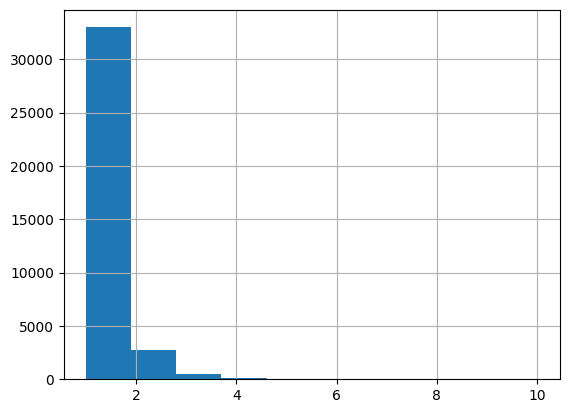

In [4]:
df['number_of_fatalities'].hist(bins=10)

In [5]:
# create a function to print errors
def print_errors(y_test, y_pred):
    print('Mean absolute error:', mean_absolute_error(y_test, y_pred))
    print('Mean squared error:', mean_squared_error(y_test, y_pred))
    print('Root mean squared error:', np.sqrt(mean_squared_error(y_test, y_pred)))
    print('R-squared error:', r2_score(y_test, y_pred))

In [6]:
# create a function to print a correlation matrix heat map
def print_corr(df, annotate=False):
    df_corr = df.corr(method='kendall', numeric_only=True)

    # display a heatmap of the correlation matrix
    sns.set(rc={"figure.figsize":(20, 16)})
    sns.heatmap(df_corr, annot=annotate, annot_kws={'size': 12}, cmap='coolwarm', vmin=-1, vmax=1)
    plt.show()

In [7]:
# scale the numerical features
cols_to_rescale = ['number_of_motor_vehicles_in_transport_mvit',
                   'number_of_occupants',
                   'day_of_crash',
                   'total_lanes_in_roadway',
                   'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
                   'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
                   'number_of_persons_in_motor_vehicles_in_transport_mvit',
                   'latitude',
                   'longitude',
                   'light_condition',
                   'number_of_drunk_drivers']

scaler = StandardScaler()
scaler.fit(df[cols_to_rescale])
rescaled_cols = scaler.transform(df[cols_to_rescale])

# create a separate dataframe
df_scaled = df.drop((['fatalities_in_vehicle', 'number_of_fatalities']), axis=1).copy()
df_scaled[cols_to_rescale] = rescaled_cols.astype('float32')

In [8]:
# cosine transform the month, day of week and hour features since they're cyclical
df_scaled['month_of_crash'] = np.cos(2 * np.pi * df_scaled['month_of_crash'] / 12)
df_scaled['day_of_week'] = np.cos(2 * np.pi * df_scaled['day_of_week'] / 7)
df_scaled['hour_of_crash'] = np.cos(2 * np.pi * df_scaled['hour_of_crash'] / 24)

df_scaled['month_of_crash'] = df_scaled['month_of_crash'].astype('float32')
df_scaled['day_of_week'] = df_scaled['day_of_week'].astype('float32')
df_scaled['hour_of_crash'] = df_scaled['hour_of_crash'].astype('float32')

## Model using RFE, CV and XGBClassifier:

In [9]:
# use recursive feature elimination with cross-validation to get a ranking of the features in terms of importance
X_train, X_test, y_train, y_test = train_test_split(df_scaled, df['number_of_fatalities'], test_size=0.2, random_state=21)

xgbr_model = xgb.XGBRegressor(objective='count:poisson')

rfe_cv = RFECV(estimator=xgbr_model,
               step=50,
               cv=3,
               scoring='neg_mean_squared_error',
               n_jobs=-1)

rfe_cv.fit(X_train, y_train)

RFECV(cv=3,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device=None,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, gamma=None, grow_policy=None,
                             importance_type=None, interaction_constraints=None,
                             learning_rate=None, max_bin=None,
                             max_cat_threshold=None, max_cat_to_onehot=None,
                             max_delta_step=None, max_depth=None,
                             max_leaves=None, min_child_weight=None,
                             missing=nan, monotone_constraints=None,
                             multi_strategy=None, n_estimators=None,
                             n_jobs=None, num_parallel_tree=None,
                             objective='count:poisson', ...),
      n_jobs=-1, scoring='neg_mean_squared_error', step=50)

In [10]:
# print the number of optimal features that RFE found
print('Optimal number of features:', rfe_cv.n_features_)

Optimal number of features: 93


In [11]:
X_train.columns[rfe_cv.support_]

Index(['number_of_motor_vehicles_in_transport_mvit', 'hour_of_crash',
       'fire_occurrence', 'number_of_parked_working_vehicles',
       'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
       'number_of_persons_in_motor_vehicles_in_transport_mvit', 'day_of_week',
       'national_highway_system', 'latitude', 'longitude', 'light_condition',
       'number_of_drunk_drivers',
       'first_harmful_event_name_Cable Barrier (Since 2008)',
       'first_harmful_event_name_Other Object (Not Fixed)',
       'first_harmful_event_name_Railway Vehicle', 'manner_of_collision_2',
       'registration_state_name_Multiple State Registrations',
       'registration_state_name_Tennessee',
       'registration_state_name_Washington',
       'registration_state_name_West Virginia',
       'registration_state_name_Wyoming', 'vehicle_make_name_GMC',
       'vehicle_make_name_Hyundai', 'vehicle_make_name_Isuzu',
       'vehicle_make_name_Peterbilt', 'vehicle_model_29', 'vehicle_model_44',


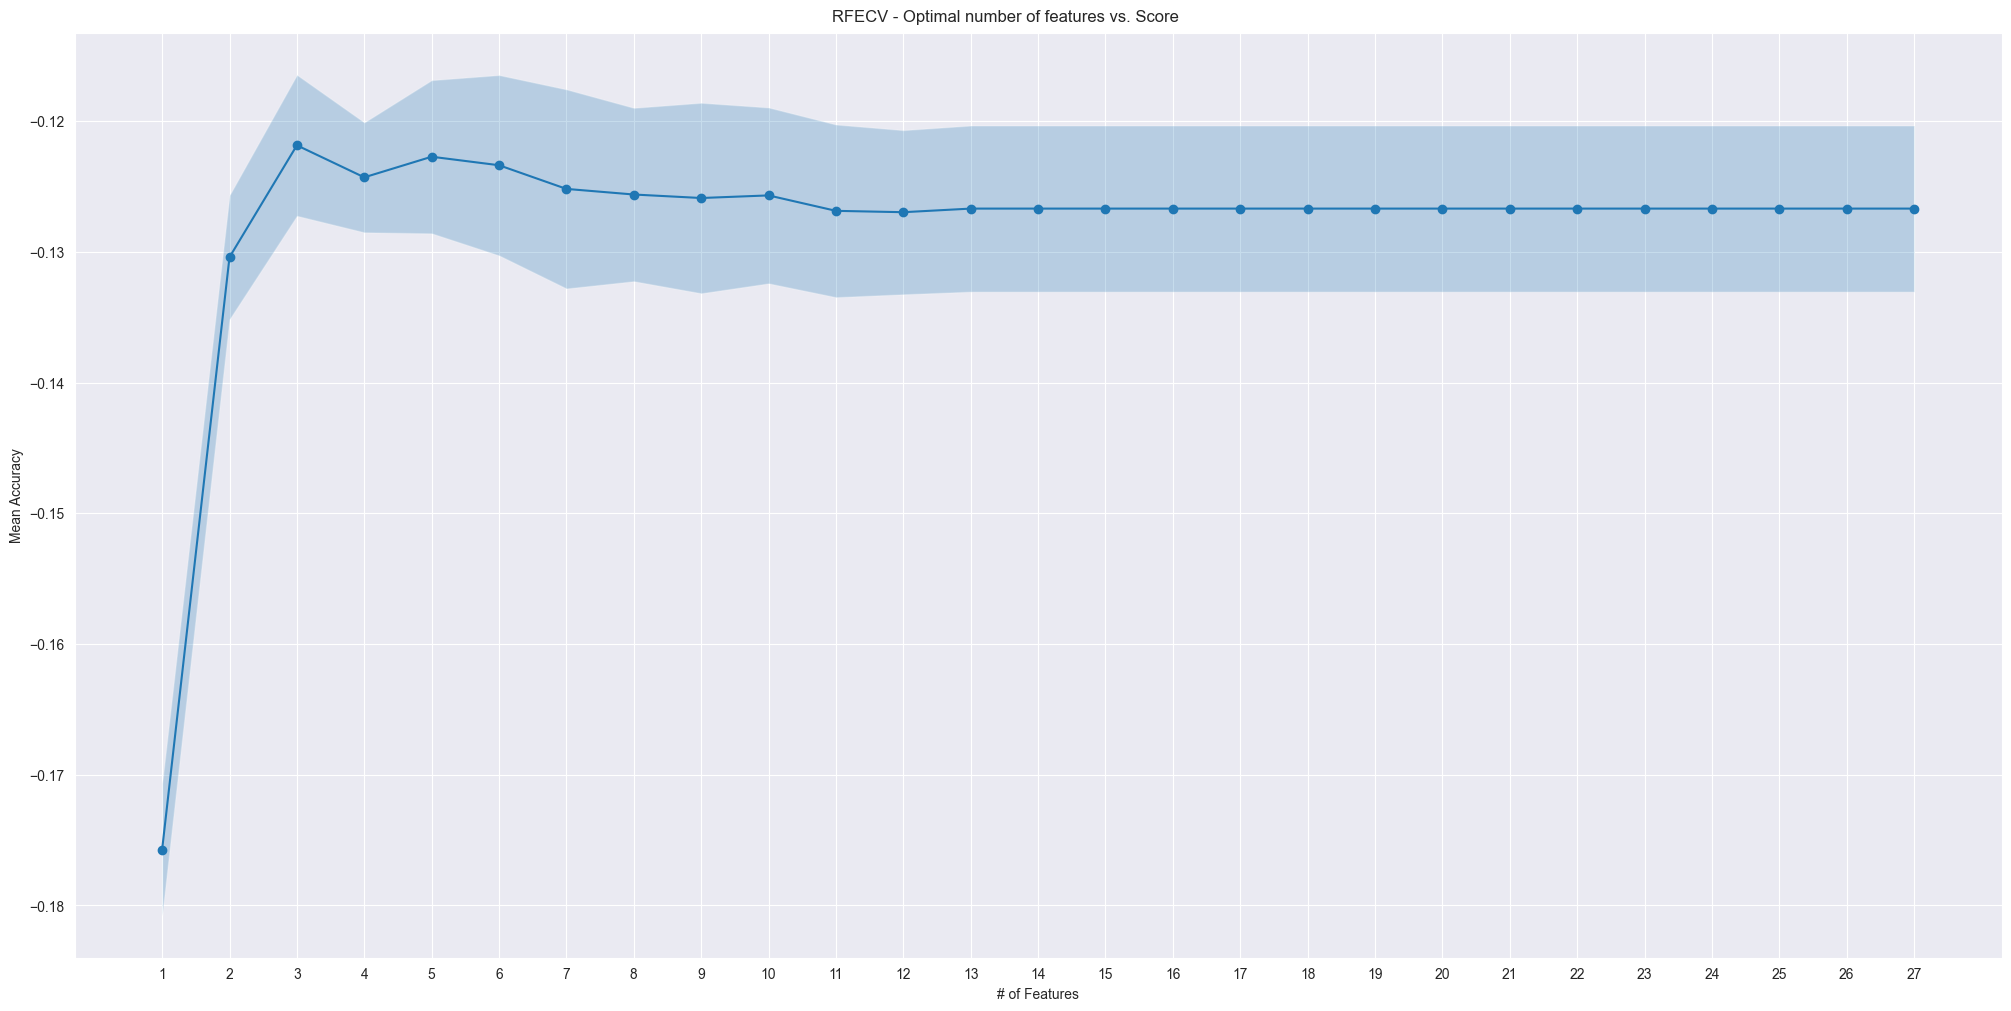

In [12]:
# print the cross-validation scores for each level of features being used
cv_scores = rfe_cv.cv_results_['mean_test_score']
cv_scores_std = rfe_cv.cv_results_['std_test_score']
number_of_features = np.arange(1, len(cv_scores) + 1, 1)

sns.set_style('darkgrid')
fig, ax = plt.subplots(figsize=(20,10), layout='constrained')
fig.suptitle("RFECV - Optimal number of features vs. Score")
plt.xlabel("# of Features")
ax.set_xticks([i for i in number_of_features])
plt.ylabel("Mean Accuracy")
plt.plot(number_of_features, cv_scores, 'o-')
plt.fill_between(number_of_features, cv_scores - cv_scores_std, cv_scores + cv_scores_std, alpha=0.25)
plt.show()

In [13]:
# Seems like 3 features gives the optimal amount of accuracy

## Model using XGB feature importance:

In [14]:
# use XGBoost and feature importance to get the most important features
xgb_all = xgb.XGBRegressor(objective='count:poisson')
xgb_all.fit(X_train, y_train)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

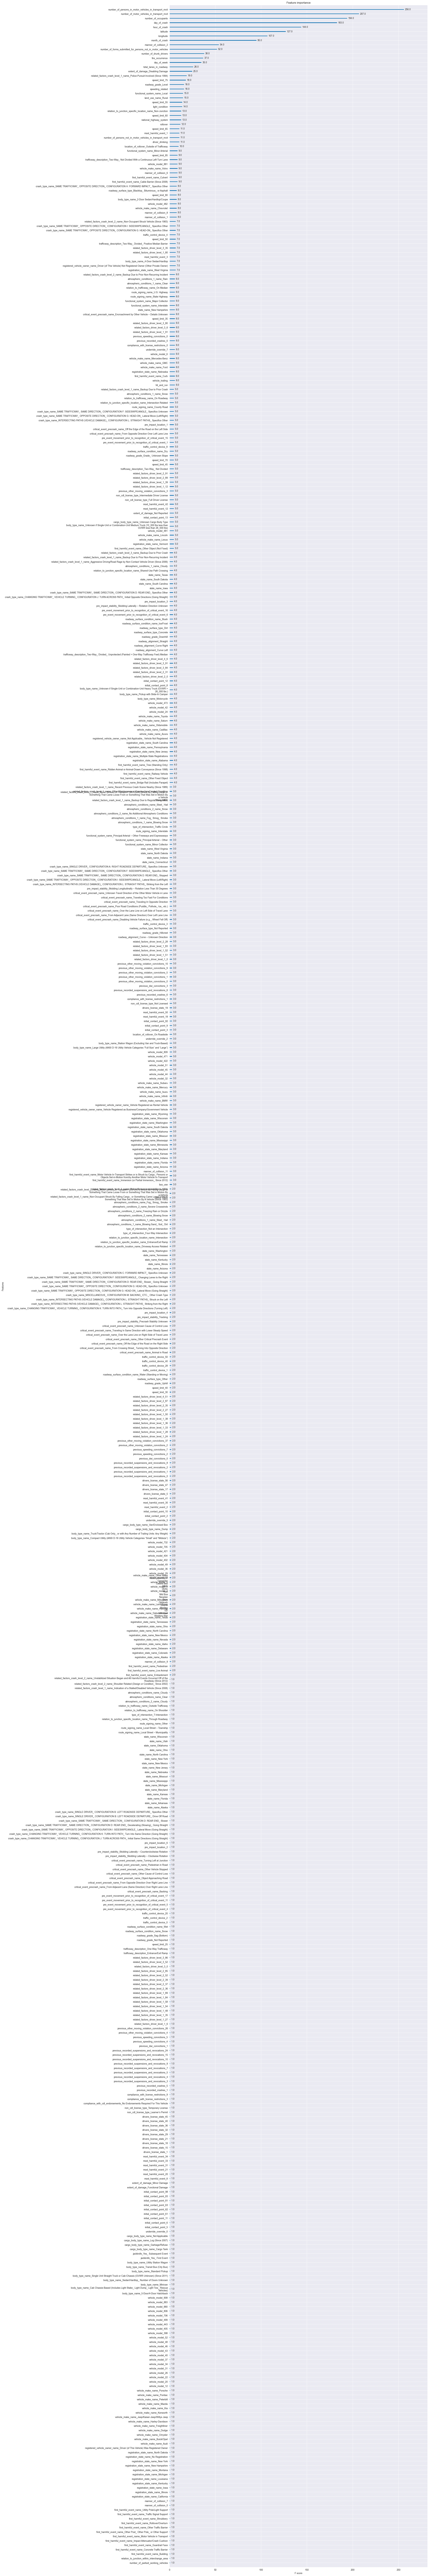

In [15]:
# use the plot_importance function to plot the most important features
fig, ax = plt.subplots(figsize=(20,200))
xgb.plot_importance(xgb_all, ax=ax)
plt.show()

In [16]:
# save predictions from the test set
y_pred = xgb_all.predict(X_test)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

In [17]:
# evaluate the results
print_errors(y_test, y_pred)

Mean absolute error: 0.16863647886891045
Mean squared error: 0.1298327804189745
Root mean squared error: 0.36032316109150475
R-squared error: 0.31784079998269976


In [18]:
# get a dict of the features sorted by feature importance
xgb_all_booster = xgb_all.get_booster()
importance_dict = xgb_all_booster.get_score(importance_type='weight')
sorted_importance = sorted(importance_dict.items(), key=lambda x: x[1], reverse=True)
xgb_feats = [feature[0] for feature in sorted_importance]

In [19]:
# save the 15 most important features
X = df_scaled[xgb_feats[:15]]
y_class = df['fatalities_in_vehicle']
y_reg = df['number_of_fatalities']

In [20]:
# create another train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=21)

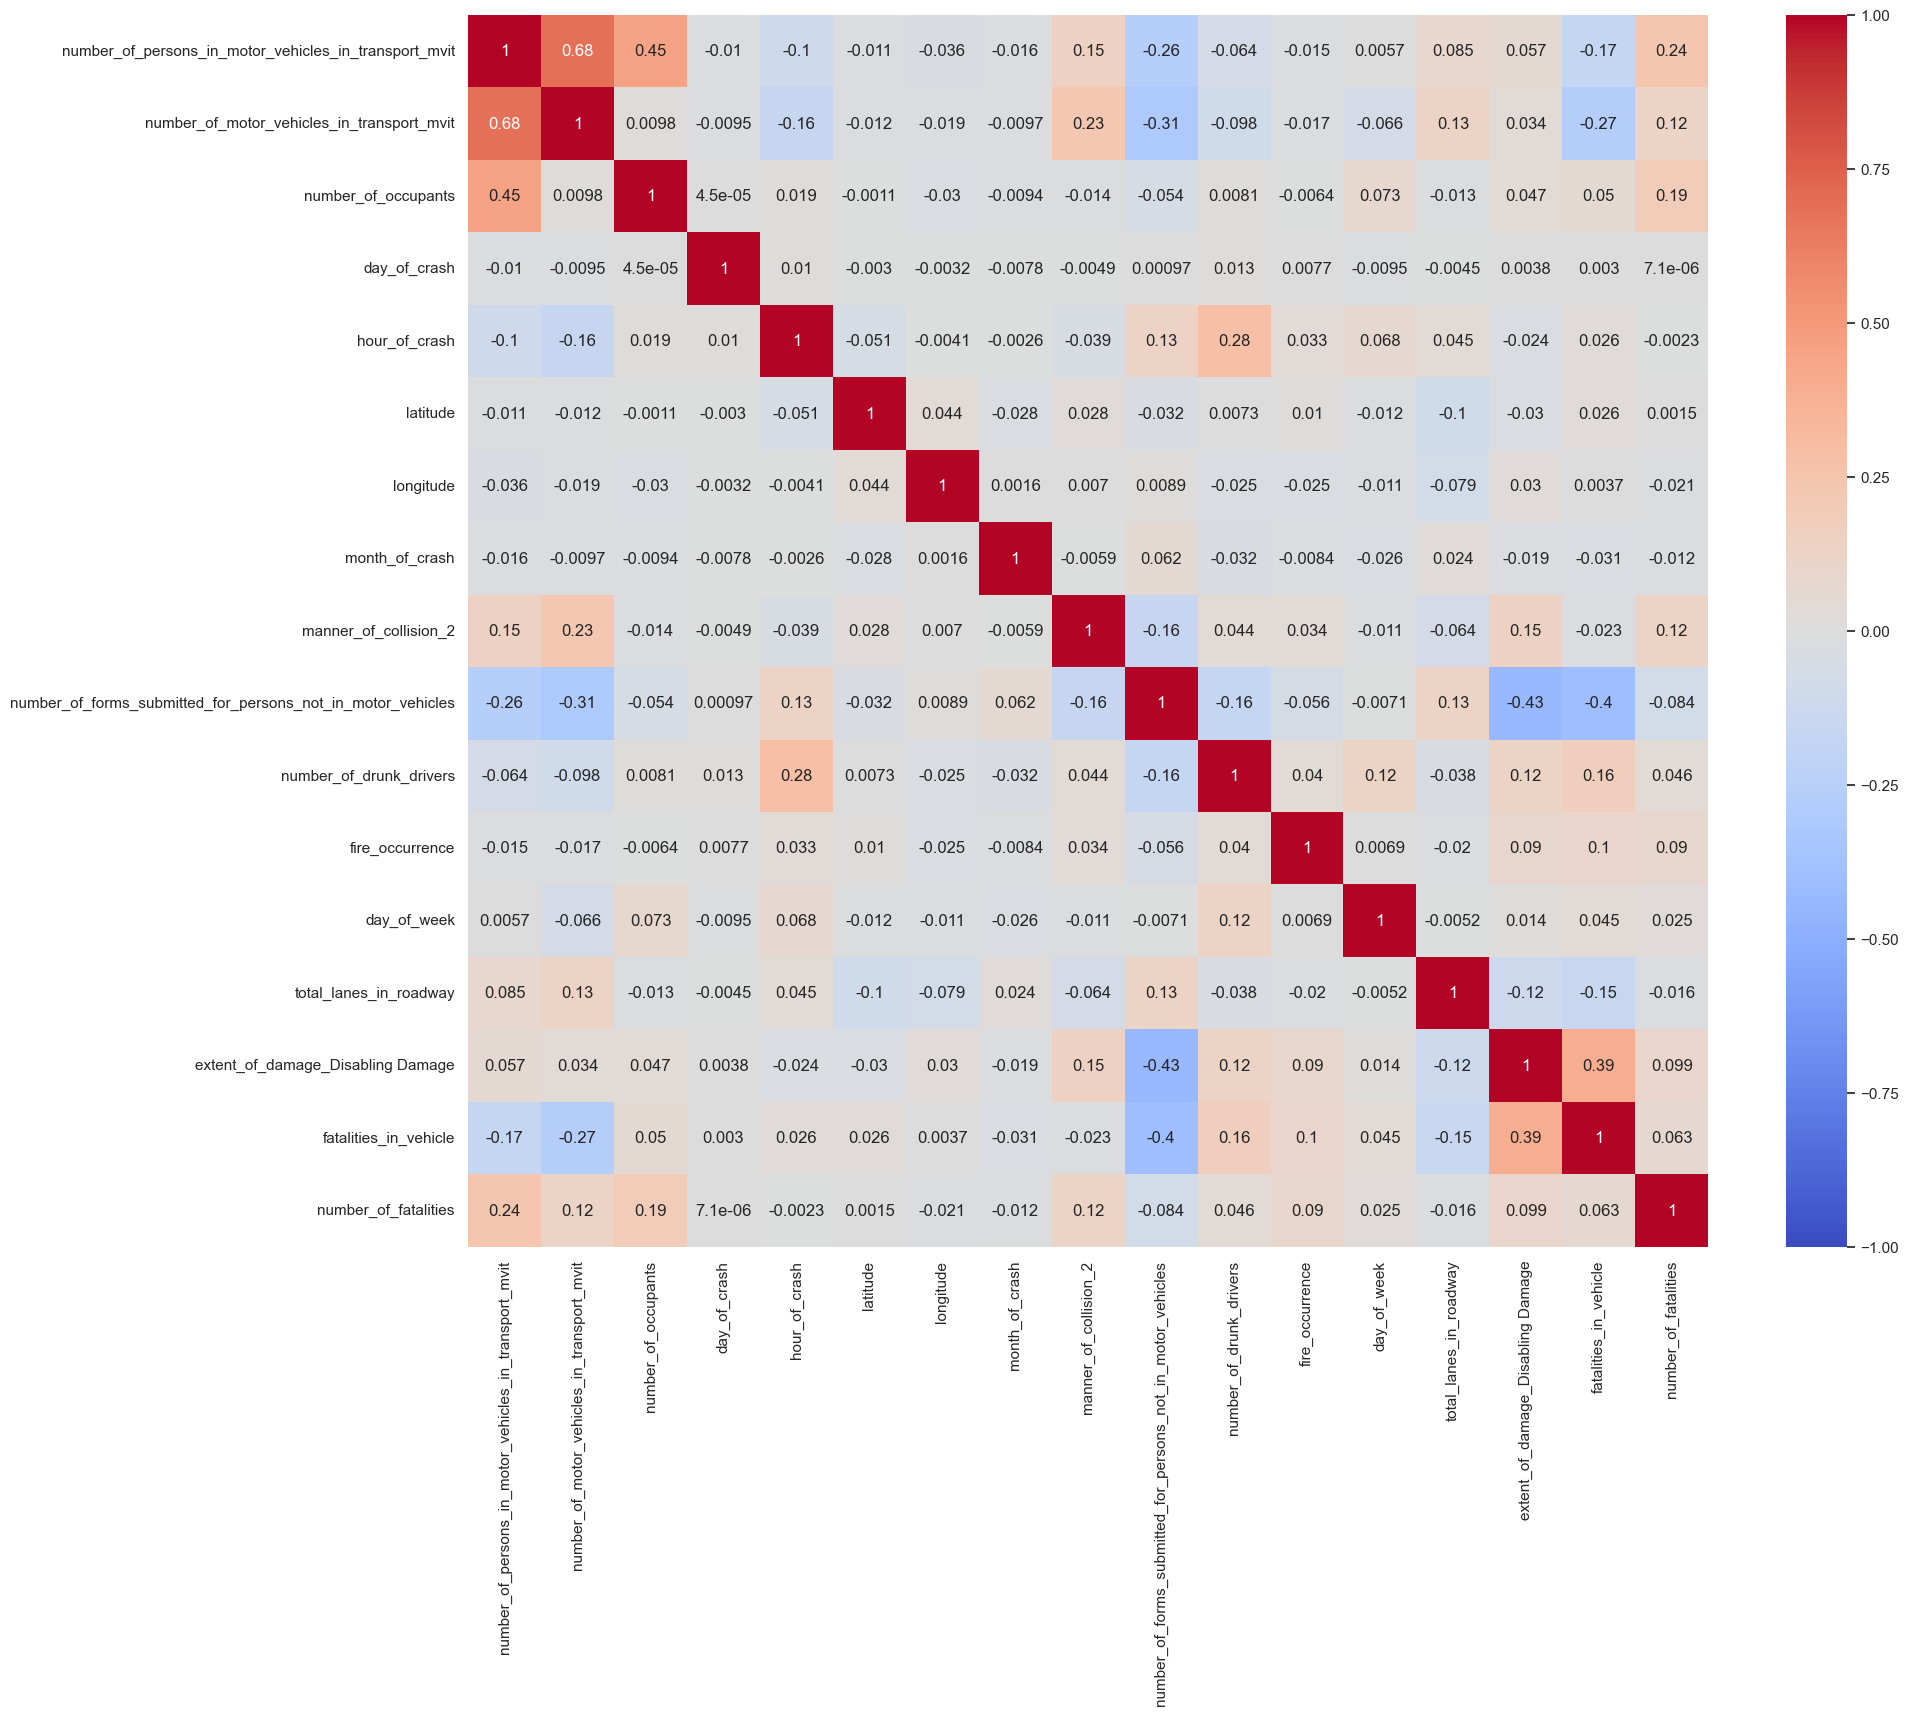

In [21]:
# print correlation matrix heat map
print_corr(pd.concat([X, y_class, y_reg], axis=1), annotate=True)

In [22]:
# fit a model
xgb_model = xgb.XGBRegressor(objective='count:poisson')
xgb_model.fit(X_train, y_train)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [23]:
# save predictions from the test set
y_pred = xgb_model.predict(X_test)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

In [24]:
# evaluate the results
print_errors(y_test, y_pred)

Mean absolute error: 0.15915544727782344
Mean squared error: 0.11750219727598057
Root mean squared error: 0.3427859350614908
R-squared error: 0.3826273716437828


## Model using variance threshold:

In [25]:
# use variance threshold to get a set of features that contribute the most to the variance of data
vt = VarianceThreshold(0.20)
df_vt = vt.fit_transform(df_scaled)

In [26]:
# save the features that met the threshold
important_features = df_scaled.columns[vt.get_support()]
print('Features:\n', important_features, '\nNumber of features:', len(important_features))

Features:
 Index(['number_of_motor_vehicles_in_transport_mvit', 'number_of_occupants',
       'day_of_crash', 'month_of_crash', 'hour_of_crash',
       'total_lanes_in_roadway',
       'number_of_forms_submitted_for_persons_not_in_motor_vehicles',
       'number_of_persons_not_in_motor_vehicles_in_transport_mvit',
       'number_of_persons_in_motor_vehicles_in_transport_mvit', 'day_of_week',
       'national_highway_system', 'latitude', 'longitude', 'light_condition',
       'number_of_drunk_drivers',
       'first_harmful_event_name_Motor Vehicle in Transport',
       'manner_of_collision_0',
       'registered_vehicle_owner_name_Driver (of This Vehicle) Not Registered Owner (Other Private Owner)',
       'registered_vehicle_owner_name_Driver (of This Vehicle) Was Registered Owner',
       'body_type_name_4-Door Sedan/Hardtop', 'initial_contact_point_12',
       'most_harmful_event_12', 'compliance_with_license_restrictions_0',
       'related_factors_driver_level_1_0',
       'traffi

In [27]:
# save X and y based on the features that met the threshold of the Variance Threshold
X_vt = df_scaled[important_features]

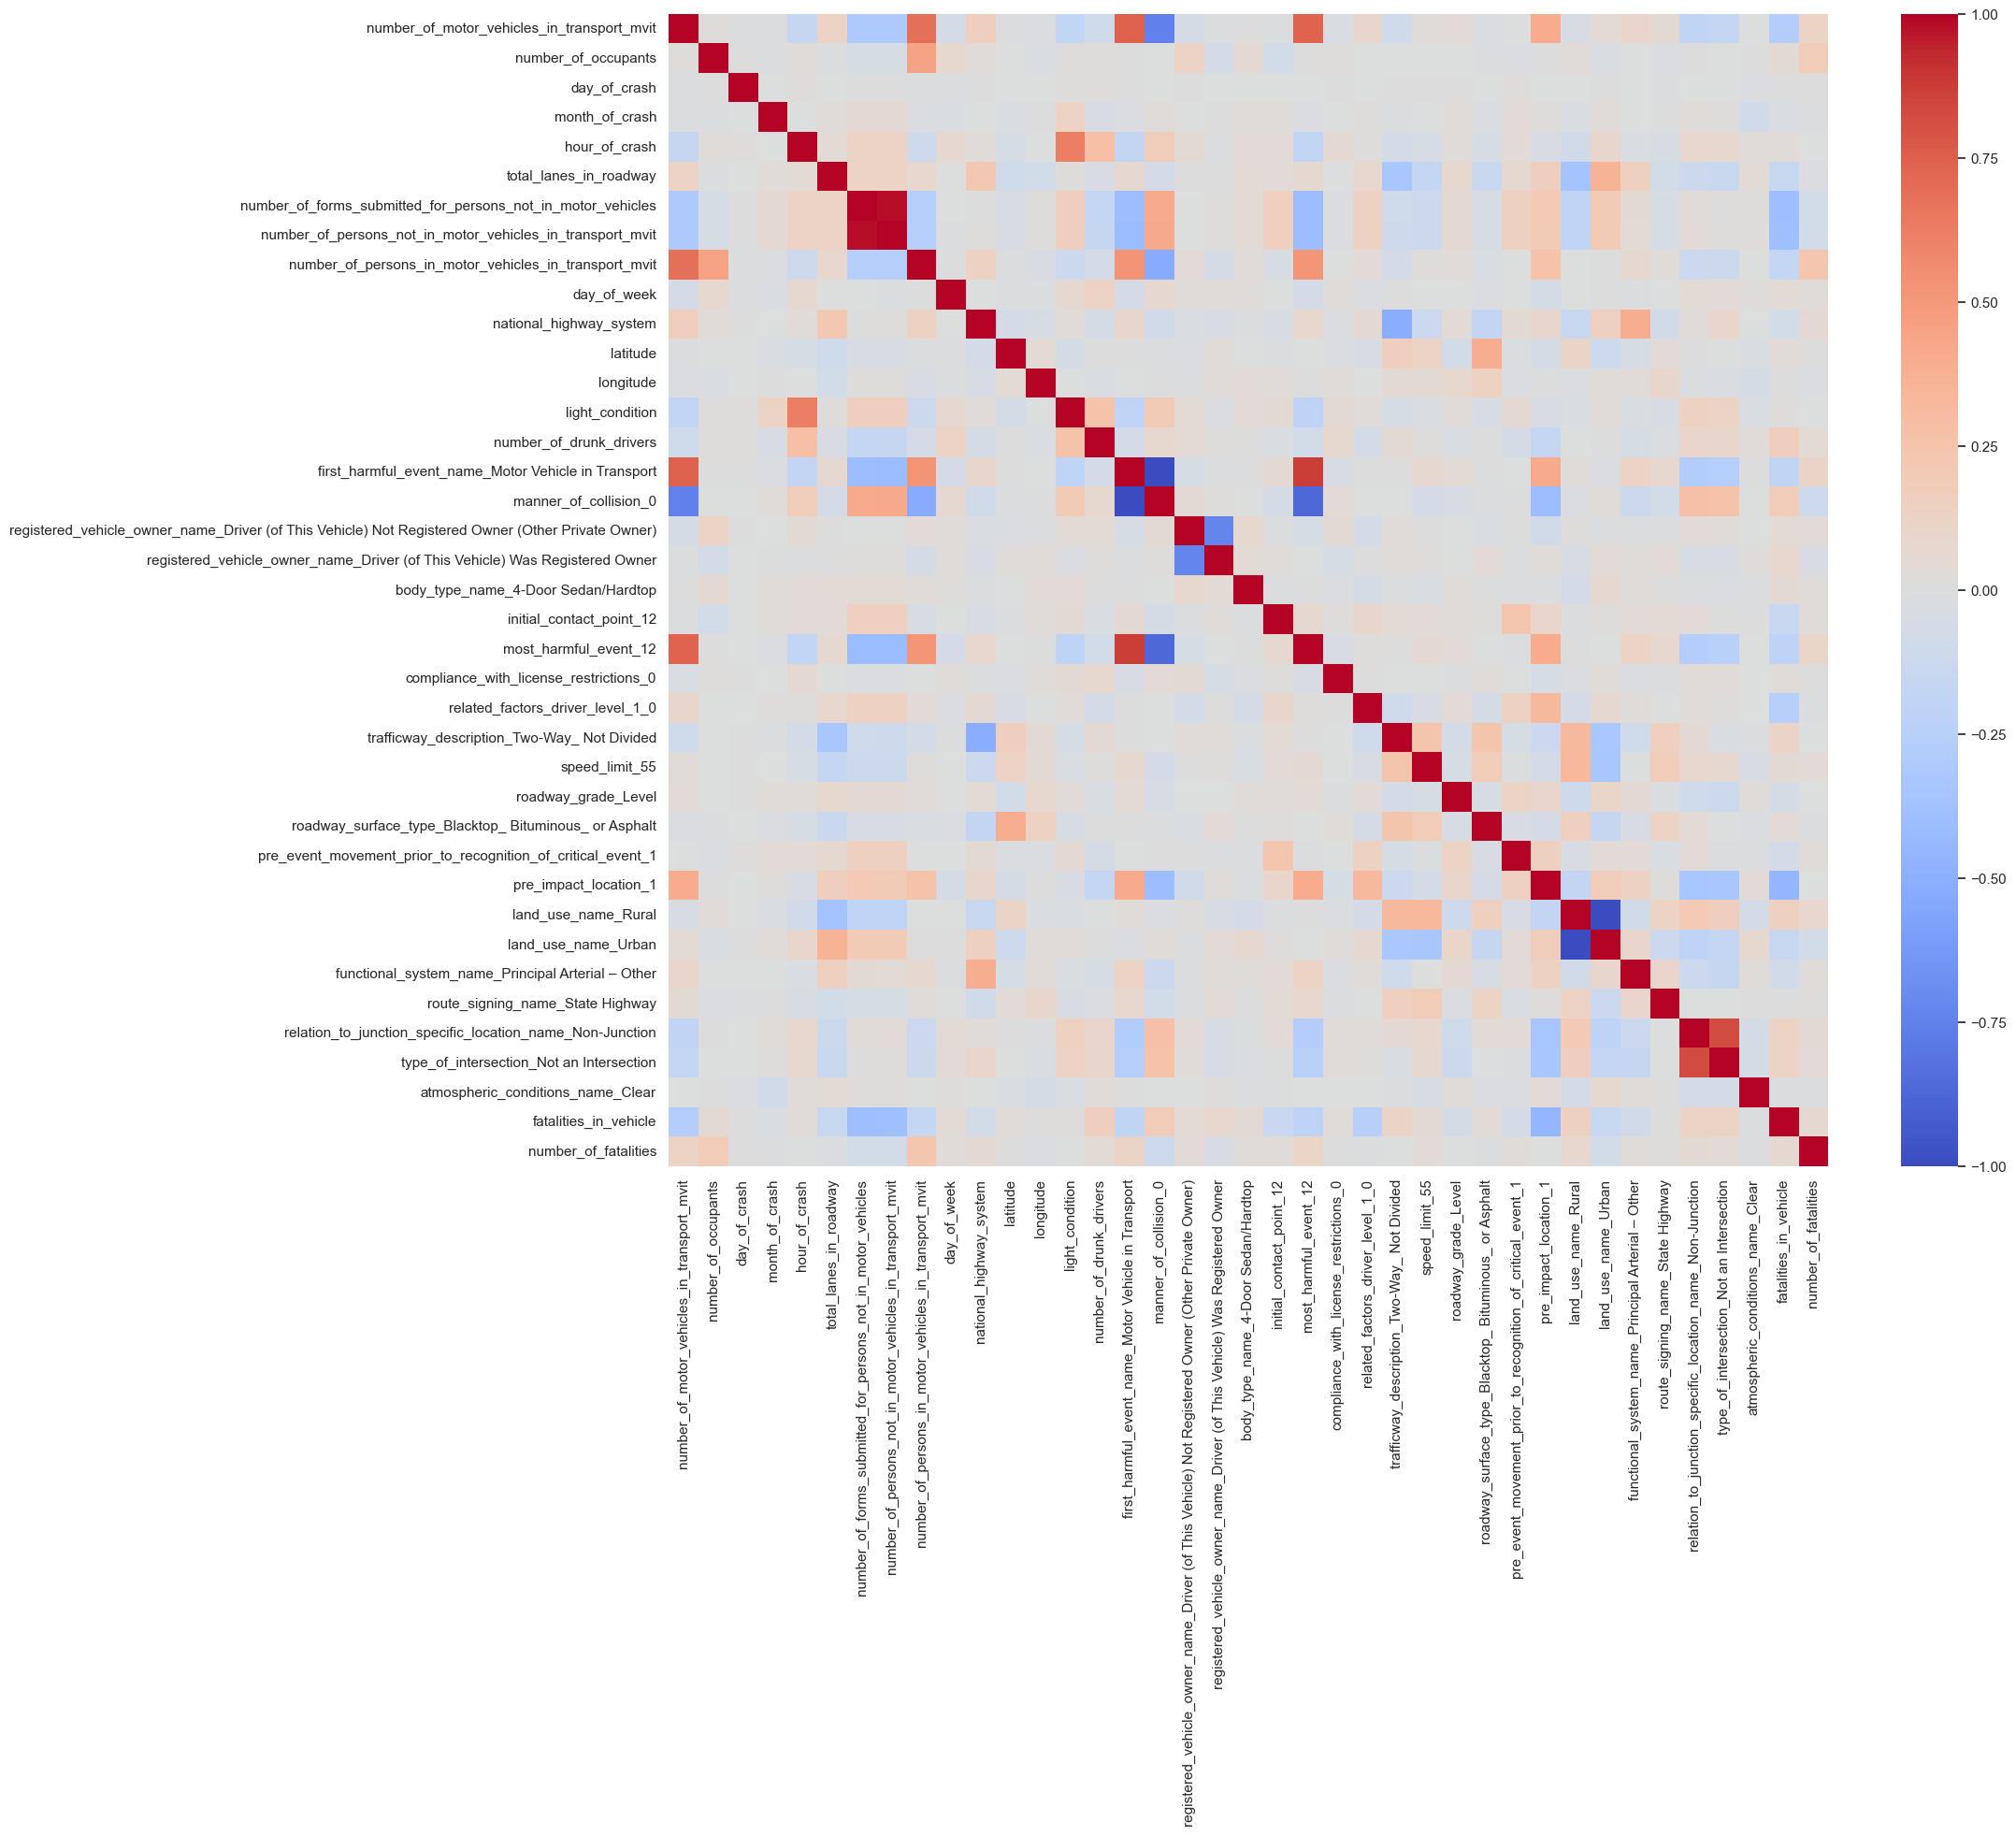

In [28]:
# print correlation matrix heat map
print_corr(pd.concat([X_vt, y_class, y_reg], axis=1), annotate=False)

In [29]:
# create another train-test split based on the variance threshold
X_train, X_test, y_train, y_test = train_test_split(X_vt, y_reg, test_size=0.2, random_state=21)

In [30]:
# fit a model
xgb_model = xgb.XGBRegressor(objective='count:poisson')
xgb_model.fit(X_train, y_train)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [31]:
# save predictions from the test set
y_pred = xgb_model.predict(X_test)

C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
C:\Users\Shaief\anaconda3\envs\lhl_env\lib\site-packages\xgboost\data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  return is_int

In [32]:
# evaluate the results
print_errors(y_test, y_pred)

Mean absolute error: 0.16304895710466455
Mean squared error: 0.12206657605287166
Root mean squared error: 0.3493802742755688
R-squared error: 0.3586455007713254


## Model using random search and top 15 most important features

In [33]:
# create another train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y_reg, test_size=0.2, random_state=21)

In [34]:
# use random search to improve the model while simulatenously mitigating overfitting

# set up the parameter grid
params = {'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
          'learning_rate': [0.1, 0.05, 0.01, 0.005, 0.001],
          'n_estimators': [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000],
          'gamma': [0, .01, 0.1, 0.25, 0.5, 1, 1.5, 2, 2.5, 3, 4, 5],
          'min_child_weight': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
          'subsample': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
          'colsample_bytree': [0.2, 0.4, 0.6, 0.8, 1.0],
          #'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1.0],
          #'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1.0],
          'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
          'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4],
          'objective':['count:poisson']}

# 2nd set of parameters just in case the first set is too compute and/or memory heavy
params2 = {#'max_depth': [2, 5, 8],
          'learning_rate': [0.1, 0.01, 0.001],
          'n_estimators': [100, 500, 1000],
          'gamma': [0.01, 0.1],
          'min_child_weight': [1, 4, 7],
          'subsample': [0.5, 1.0],
          'colsample_bytree': [0.5, 1.0],
          #'colsample_bylevel': [0.2, 0.4, 0.6, 0.8, 1.0],
          #'colsample_bynode': [0.2, 0.4, 0.6, 0.8, 1.0],
          'reg_alpha': [0, 0.5, 1],
          'reg_lambda': [0, 0.5, 1],
          'objective':['count:poisson']}

In [35]:
# suppress future warnings to save on CPU cycles
warnings.filterwarnings('ignore', category=FutureWarning)

# initialize a second XGB classifier for grid search and do the grid search
xgb_model2 = xgb.XGBRegressor()

rs = RandomizedSearchCV(estimator=xgb_model2, param_distributions=params, cv=5, scoring='neg_mean_squared_error', n_iter=25, verbose=3, random_state=21)
rs.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.130 total time=   0.4s
[CV 2/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.135 total time=   0.4s
[CV 3/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.120 total time=   0.4s
[CV 4/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.128 total time=   0.4s
[CV 5/5] END colsample_bytree=0.8, gamma=0.01, lea

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                          0.005, 0.001],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'objective': ['count:poisson'],
                                        'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
                                        'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5,
                                                       3, 3.5, 4],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   random_state=21, scoring='neg_mean_squared_error',
                   verbose=3)

In [36]:
# get the best parameters and the best score
print('Best score:', rs.best_score_)
print('Best parameters:', rs.best_params_)
best_xgb_params = rs.best_params_

Best score: -0.0977261529730088
Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.25, 'objective': 'count:poisson', 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.6}


In [37]:
# build a new model using the best parameters
xgb_best_model = xgb.XGBRegressor(**best_xgb_params)
xgb_best_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [38]:
# make new predictions
y_best_pred = xgb_best_model.predict(X_test)

In [39]:
# evaluate this new model
print_errors(y_test, y_best_pred)

Mean absolute error: 0.13455441711333194
Mean squared error: 0.09311404402758888
Root mean squared error: 0.3051459389006986
R-squared error: 0.5107660670960049


## Evaluation using 2016 data:

In [40]:
# import the 2016 formatted data for testing
df_2016 = pd.read_csv('../data/accident_vehicle_2016_formatted.csv')

In [41]:
rescaled_cols_2016 = scaler.transform(df_2016[cols_to_rescale])

# create a separate dataframe
df_2016_scaled = df_2016.drop((['fatalities_in_vehicle', 'number_of_fatalities']), axis=1).copy()
df_2016_scaled[cols_to_rescale] = rescaled_cols_2016.astype('float32')

In [42]:
# cosine transform the month, day of week and hour features since they're cyclical
df_2016_scaled['month_of_crash'] = np.cos(2 * np.pi * df_2016_scaled['month_of_crash'] / 12)
df_2016_scaled['day_of_week'] = np.cos(2 * np.pi * df_2016_scaled['day_of_week'] / 7)
df_2016_scaled['hour_of_crash'] = np.cos(2 * np.pi * df_2016_scaled['hour_of_crash'] / 24)

df_2016_scaled['month_of_crash'] = df_2016_scaled['month_of_crash'].astype('float32')
df_2016_scaled['day_of_week'] = df_2016_scaled['day_of_week'].astype('float32')
df_2016_scaled['hour_of_crash'] = df_2016_scaled['hour_of_crash'].astype('float32')

In [43]:
#create a separate dataframe to evaluate XGB model that uses all features
df_2016_scaled_all = df_2016_scaled.copy()

for col in df_scaled.columns:
    if col not in df_2016_scaled_all.columns:
        df_2016_scaled_all[col] = 0

In [44]:
X_16 = df_2016_scaled_all[xgb_feats[:15]]
y_reg_16 = df_2016['number_of_fatalities']

In [45]:
# make new predictions
y_pred_16 = xgb_best_model.predict(X_16)

In [46]:
# evaluate this new model
print_errors(y_reg_16, y_pred_16)

Mean absolute error: 0.18242566727087386
Mean squared error: 0.15420572058116142
Root mean squared error: 0.3926903622208742
R-squared error: 0.120889401429357


In [47]:
#evaluate model that was built using all features
y_pred_all_16 = xgb_all.predict(df_2016_scaled_all[df_scaled.columns])

# evaluate this new model
print_errors(y_reg_16, y_pred_all_16)

Mean absolute error: 0.18005349960276656
Mean squared error: 0.14985510836140264
Root mean squared error: 0.3871112351268078
R-squared error: 0.14569178423491513


## Build a model using data from 2015 and 2016

In [48]:
df_combined = pd.concat([df, df_2016], axis=0)
y = pd.concat([y_reg, y_reg_16], axis=0)

In [49]:
# check which features have null values
print(df_combined.columns[(df_combined.isna().sum() > 0).tolist()])

Index(['registration_state_name_American Samoa',
       'registration_state_name_Other Foreign Country',
       'vehicle_make_name_Austin/Austin Healey', 'vehicle_make_name_Peugeot',
       'vehicle_model_58', 'vehicle_model_474', 'vehicle_model_731',
       'vehicle_model_905',
       'body_type_name_Light-Truck-Based Motorhome (Chassis Mounted)',
       'body_type_name_Unknown Truck Type',
       'body_type_name_Utility Unknown Body', 'most_harmful_event_51',
       'related_factors_vehicle_level_1_33',
       'related_factors_vehicle_level_2_44', 'drivers_license_state_13',
       'drivers_license_state_93', 'non_cdl_license_type_Unknown License Type',
       'previous_recorded_crashes_10',
       'previous_recorded_suspensions_and_revocations_32',
       'previous_recorded_suspensions_and_revocations_37',
       'previous_recorded_suspensions_and_revocations_38',
       'previous_recorded_suspensions_and_revocations_39',
       'previous_recorded_suspensions_and_revocations_46',
  

In [50]:
# fill the null values with false
df_combined.fillna(value=False, inplace=True)

In [51]:
# rescale the data
scaler = StandardScaler()
scaler.fit(df_combined[cols_to_rescale])
rescaled_cols = scaler.transform(df_combined[cols_to_rescale])

# create a separate dataframe
df_combined_scaled = df_combined.drop((['fatalities_in_vehicle', 'number_of_fatalities']), axis=1).copy()
df_combined_scaled[cols_to_rescale] = rescaled_cols.astype('float32')

In [52]:
# cosine transform the month, day of week and hour features since they're cyclical
df_combined_scaled['month_of_crash'] = np.cos(2 * np.pi * df_combined_scaled['month_of_crash'] / 12)
df_combined_scaled['day_of_week'] = np.cos(2 * np.pi * df_combined_scaled['day_of_week'] / 7)
df_combined_scaled['hour_of_crash'] = np.cos(2 * np.pi * df_combined_scaled['hour_of_crash'] / 24)

df_combined_scaled['month_of_crash'] = df_combined_scaled['month_of_crash'].astype('float32')
df_combined_scaled['day_of_week'] = df_combined_scaled['day_of_week'].astype('float32')
df_combined_scaled['hour_of_crash'] = df_combined_scaled['hour_of_crash'].astype('float32')

In [53]:
# create a train test split
X_train, X_test, y_train, y_test = train_test_split(df_combined_scaled[xgb_feats[:15]], y, test_size=0.2, random_state=21)

In [54]:
# use random search to find the best model
xgb_model3 = xgb.XGBRegressor()

rs2 = RandomizedSearchCV(estimator=xgb_model3, param_distributions=params, cv=5, scoring='neg_mean_squared_error', n_iter=25, verbose=3, random_state=21)
rs2.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.130 total time=   0.6s
[CV 2/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.143 total time=   0.6s
[CV 3/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.133 total time=   0.6s
[CV 4/5] END colsample_bytree=0.8, gamma=0.01, learning_rate=0.1, max_depth=4, min_child_weight=9, n_estimators=700, objective=count:poisson, reg_alpha=0.75, reg_lambda=2.5, subsample=0.6;, score=-0.128 total time=   0.6s
[CV 5/5] END colsample_bytree=0.8, gamma=0.01, lea

RandomizedSearchCV(cv=5,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                                          0.005, 0.001],
                                        'max_depth': [2, 3, 4, 5, 6, 7, 8, 9,
                                                      10],
                                        'min_child_weight': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10],
                                        'n_estimators': [100, 200, 300, 400,
                                                         500, 600, 700, 800,
                                                         900, 1000],
                                        'objective': ['count:poisson'],
                                        'reg_alpha': [0, 0.25, 0.5, 0.75, 1],
                                        'reg_lambda': [0, 0.5, 1, 1.5, 2, 2.5,
                                                       3, 3.5, 4],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1]},
                   random_state=21, scoring='neg_mean_squared_error',
                   verbose=3)

In [55]:
# get the best parameters and the best score
print('Best score:', rs2.best_score_)
print('Best parameters:', rs2.best_params_)
best_xgb_params2 = rs2.best_params_

Best score: -0.10618261956661672
Best parameters: {'subsample': 0.8, 'reg_lambda': 1, 'reg_alpha': 0.25, 'objective': 'count:poisson', 'n_estimators': 500, 'min_child_weight': 3, 'max_depth': 8, 'learning_rate': 0.1, 'gamma': 0.01, 'colsample_bytree': 0.6}


In [56]:
# build a new model using the best parameters
xgb_best_model2 = xgb.XGBRegressor(**best_xgb_params2)
xgb_best_model2.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.6, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=0.01, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=8, max_leaves=None,
             min_child_weight=3, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='count:poisson', ...)

In [57]:
# make new predictions
y_best_pred2 = xgb_best_model2.predict(X_test)

In [58]:
# evaluate this new model
print_errors(y_test, y_best_pred2)

Mean absolute error: 0.14728143571818897
Mean squared error: 0.10155120074093466
Root mean squared error: 0.3186709913703076
R-squared error: 0.43467033172326497
